In [2]:
# get api key from your .env file
import os
import requests

from dotenv import load_dotenv  # if missing this module, simply run `pip install python-dotenv`

load_dotenv()
API_KEY = os.getenv('POLYGON_API_KEY')
ALPHA_ADVANTAGE_API_KEY = os.getenv('ALPHA_ADVANTAGE_API_KEY')

print(API_KEY)
print(ALPHA_ADVANTAGE_API_KEY)

eYFFqMh3r0gYcJ4hBsJQTxsSS8s10mZB
HJ48VNC66Z0Q01V9


<h3> Dataset One: POLYGON Daily Data </h3>

Pulled from Polygon per day, with open, high, low, and close for the entire market (total 10k+). Polygon has a API call limit of 5 / minute, so I can write a script to make five calls per minute to gather a year of data. 

<b> Potential limitations: </b> With daily data, perhaps the data will not be granular enough to provide accurate results.


<b> After EDA: </b> Seems like using whole market data will be far too many data processing. Even with just 10 days of data, takes significant computing. Will be much more effective to narrow down to a handful of specific stocks, or focus on a specific industry.

In [3]:
import datetime
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def get_data(year, month, day, numDays):
    waitCounter = 0
    return_df = pd.DataFrame()
    date = datetime.date(year, month, day)
    for i in range(numDays):
        payload = {'adjusted': 'true', 'include_otc': 'false','apiKey':API_KEY}
        URL = 'https://api.polygon.io/v2/aggs/grouped/locale/us/market/stocks/' + date.strftime("%Y-%m-%d")
        req = requests.get(URL, params=payload)

        if "results" in req.json():
            dat = (req.json())['results']

            dat_df = pd.DataFrame(dat)
            dat_df['date'] = date.strftime("%Y-%m-%d")
            return_df = pd.concat([return_df, dat_df], ignore_index=True)

        date += datetime.timedelta(days=1)
        if(date.weekday() == 5):
            date += datetime.timedelta(days=2)

        # 5 API call / minute limit for free account
        waitCounter += 1
        if(waitCounter >= 5):
            time.sleep(65)
            waitCounter = 0
        
    return return_df


In [4]:
# daily_dat = get_data(2023, 1, 9, 9)
# daily_dat.to_json('daily_data.json', orient = 'split', compression = 'infer', index = 'true')

df = pd.read_json('daily_data.json', orient ='split', compression = 'infer')


In [5]:
daily_df = df
daily_df['percent_change'] = 2 * (daily_df['c'] - daily_df['o']) / (daily_df['c'] + daily_df['o'])

# daily_df['price_change'] = 0.0
# for index, row in df.iterrows():
#    prev_daytime = row['date'] - datetime.timedelta(days=1)
#    if(prev_daytime in df['date'].unique()):
#        prev_day = daily_df.where((daily_df['T'] == row['T']) & (daily_df['date'] == prev_daytime))
#        row['price_change'] = row['vw'] - prev_day['vw']


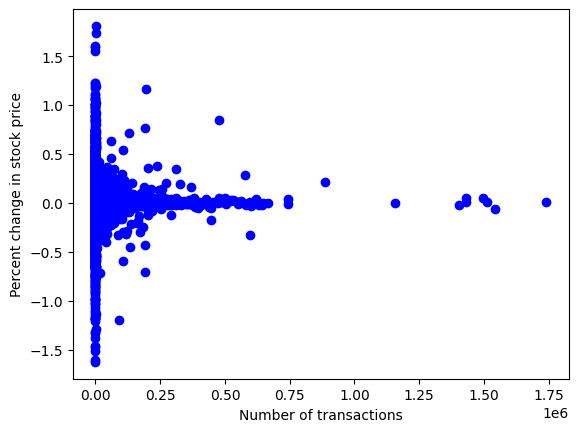

In [6]:
# see if # of transactions has an impact of percent change

plt.scatter(daily_df['n'], daily_df["percent_change"], color = "Blue")
plt.xlabel("Number of transactions")
plt.ylabel("Percent change in stock price")
plt.show()

<h3> Dataset Two: POLYGON Aggregates </h3>

Pulled from POLYGON per stock, minute by minute data for an individual stock. If I choose to focus on a specific market and pick a set of specific stocks, can create a script to pull all of the data. Limit of 50000 base aggregate bars (by minute) per query. Due to this, must pull data in two-month chunks (which means that we can approximately pull a year of data for a single stock in a bit over a minute).

<b> After EDA: </b> I believe that using POLYGON may be a more effective way to obtain stock data for training, as I can control the number of stocks being tracked and thus restrict to a specific sector or industry, or even to a selection of similar stocks. Doing so will both reduce the computational load, while also allowing for the user to influence which stocks are being used to train the model. This may be helpful for identifying industry trends -- for example, stocks in a certain industry may trend similarly based on the performance of the industry, which is a metric that would not be idenfied when training on the entire market.

In [18]:
from dateutil.relativedelta import relativedelta
import math

# payload = {'adjusted': 'true', 'sort': 'asc','apiKey':API_KEY, 'limit':'50000'}
# date_start = '2022-11-01'
# date_end = '2023-01-01'
# stock = 'AAPL'
# URL = 'https://api.polygon.io/v2/aggs/ticker/' + stock + '/range/1/minute/' + date_start + '/' + date_end 

# print(URL)

# minute_req = requests.get(URL, params=payload)
payload = {'adjusted': 'true', 'sort': 'asc','apiKey':API_KEY, 'limit':'50000'}

# Please input numMonths in increments of two months
def get_individual_stock(start_year, start_month, numMonths, stocks):
    return_dict = {}
    waitCounter = 0
    for stock in stocks:
        return_df = pd.DataFrame()
        date = datetime.date(start_year, start_month, 1)
        for i in range(math.ceil(numMonths / 2)):
            end_date = date + relativedelta(months=2) - datetime.timedelta(days=1)
            URL = 'https://api.polygon.io/v2/aggs/ticker/' + stock + '/range/1/minute/' + date.strftime("%Y-%m-%d") + '/' + end_date.strftime("%Y-%m-%d") 
            req = requests.get(URL, params=payload)

            if "results" in req.json():
                dat = (req.json())['results']

                dat_df = pd.DataFrame(dat)
                dat_df['dt'] = pd.to_datetime(dat_df['t'], unit='ms')
                return_df = pd.concat([return_df, dat_df], ignore_index=True)

            date = end_date + datetime.timedelta(days=1)

            # 5 API call / minute limit for free account
            waitCounter += 1
            if(waitCounter >= 5):
                time.sleep(65)
                waitCounter = 0
            
        return_dict[stock] = return_df
    return return_dict


In [22]:
# indiv_stocks = get_individual_stock(2022, 1, 6, ['AAPL'])
# for stock in indiv_stocks:
    # indiv_stocks[stock].to_json(stock + '.json', orient = 'split', compression = 'infer', index = 'true')

In [23]:
AAPL_df = pd.read_json('AAPL.json', orient ='split', compression = 'infer')

In [24]:
AAPL_df

,v,vw,o,c,h,l,t,n,dt
0,1118,178.2357,178.26,178.21,178.26,178.21,1641200400000,65,1641200400000
1,1218,178.3315,178.33,178.31,178.34,178.31,1641200520000,26,1641200520000
2,814,178.2899,178.28,178.30,178.30,178.28,1641200580000,30,1641200580000
3,3744,178.2079,178.23,178.15,178.23,178.15,1641200640000,114,1641200640000
4,464,178.1791,178.20,178.20,178.20,178.20,1641200700000,33,1641200700000
...,...,...,...,...,...,...,...,...,...
102650,2686,137.0872,137.13,137.08,137.13,137.08,1656633300000,33,1656633300000
102651,847,137.1195,137.12,137.13,137.13,137.12,1656633360000,21,1656633360000
102652,1730,137.1173,137.12,137.12,137.12,137.12,1656633420000,25,1656633420000
102653,1064,137.0887,137.12,137.01,137.12,137.01,1656633480000,41,1656633480000


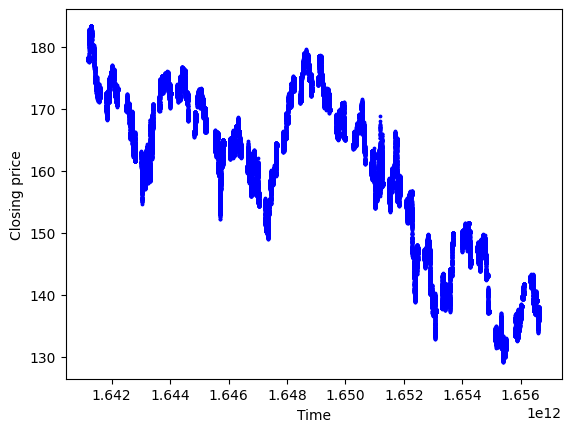

In [25]:
# see if # of transactions has an impact of percent change

plt.scatter(AAPL_df['t'], AAPL_df["c"], color = "Blue", s = 3)
plt.xlabel("Time")
plt.ylabel("Closing price")
plt.show()

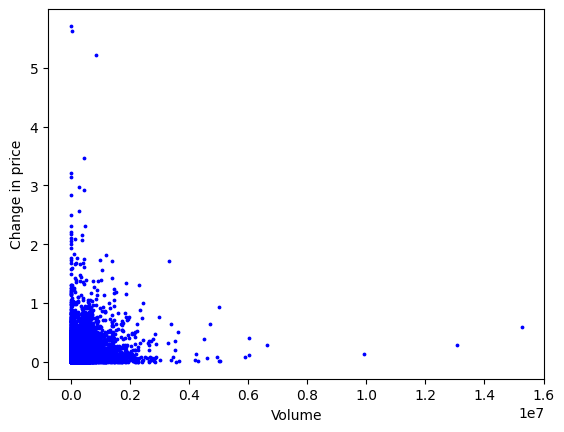

In [30]:
# see if # of transactions has an impact of percent change

AAPL_df['ABS_DIFF'] = (AAPL_df['o'] - AAPL_df['c']).abs()


plt.scatter(AAPL_df['v'], AAPL_df["ABS_DIFF"], color = "Blue", s = 3)
plt.xlabel("Volume")
plt.ylabel("Change in price")
plt.show()

<h3> Dataset Three: Alpha Advantage Fundamental Data </h3>

Pulled from 'alphadvantage' per company. If I choose to focus on a specific set of stocks, then i can pull fundamental data for a select few companies through this. This specific example is for the quarterly balance sheets for a company. I'll be able to retrieve other fundamental + stock data as well, for specific companies.

In [32]:
advantage_payload = {'function':'BALANCE_SHEET','symbol':'AAPL','apikey':ALPHA_ADVANTAGE_API_KEY}

advantage_URL = 'https://www.alphavantage.co/query'

adv_req = requests.get(advantage_URL, params=advantage_payload)

In [33]:
adv_json = adv_req.json()

quarterly_reports = adv_json['quarterlyReports']

print(len(quarterly_reports))

20


In [34]:
quarterly_reports

[{'fiscalDateEnding': '2023-03-31',
  'reportedCurrency': 'USD',
  'totalAssets': '332160000000',
  'totalCurrentAssets': '112913000000',
  'cashAndCashEquivalentsAtCarryingValue': '24687000000',
  'cashAndShortTermInvestments': '55872000000',
  'inventory': '7482000000',
  'currentNetReceivables': '35899000000',
  'totalNonCurrentAssets': '219247000000',
  'propertyPlantEquipment': '43398000000',
  'accumulatedDepreciationAmortizationPPE': '69668000000',
  'intangibleAssets': 'None',
  'intangibleAssetsExcludingGoodwill': 'None',
  'goodwill': 'None',
  'investments': '285949000000',
  'longTermInvestments': '110461000000',
  'shortTermInvestments': '31185000000',
  'otherCurrentAssets': '13660000000',
  'otherNonCurrentAssets': '65388000000',
  'totalLiabilities': '270002000000',
  'totalCurrentLiabilities': '120075000000',
  'currentAccountsPayable': '42945000000',
  'deferredRevenue': '20631000000',
  'currentDebt': '12574000000',
  'shortTermDebt': '1996000000',
  'totalNonCurrent